# SASAC Pool usage

A small notebook to visualise how many lanes are booked at St Albans' Sub Aqua Club. Since the pool is not heated, it is obviously a lot more popular in the summer months!

## Data gathering

The [month view in skedda](https://sasac.skedda.com/booking?venueuserid=3949394&viewdate=2024-06-01&viewtype=3) is populated through a JSON object that contains all bookings over two months. For example, the previous link opens the monthly booking view for June 2024. The browser populates this by fetching `https://sasac.skedda.com/bookingslists?end=2024-08-14T23:59:59.999&start=2024-05-27T00:00:00`, i.e. all bookings from 27 May to 14 August. We can simply save this JSON file using Firefox/Chrome's Developer Tools, and parse it here. Since we can extract 2 months at a time, extracting a years worth of data requires 6 page loads and maybe 30 clicks in total.

The JSON object contains personal identifying information for the logged in user (i.e. myself), but not for anyone else. The raw data is not included in this repo, but a combined CSV with all the relevant information (start time, end time, number of lanes) of the bookings is.

In [1]:
import json
import os
from datetime import timedelta
from io import StringIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astral import LocationInfo
from astral.sun import sun
from dateutil import tz

In [2]:
if os.path.exists("rawdata"):
    bookings = []
    dateColumns = ["start", "end", "endOfLastOccurrence", "createdDate"]
    for bl in os.listdir("rawdata"):
        with open(f"rawdata/{bl}", "r", encoding="utf-8") as s:
            j = json.load(s)
        modified = pd.to_datetime(os.path.getmtime(f"rawdata/{bl}"), unit="s")
        nb = pd.DataFrame(j["bookings"])
        nb[dateColumns] = nb[dateColumns].apply(pd.to_datetime)
        # we do not care about future bookings
        nb = nb[nb["end"] < modified]
        assert nb.id.is_unique
        nb = nb.set_index("id")
        bookings.append(nb)

    bookings = pd.concat(bookings)
    bookings["numSpaces"] = bookings.spaces.apply(lambda x: len(x))
    bookings = bookings[["start", "end", "createdDate", "numSpaces"]]
    ## type column: 0 is internal, 2 is unavailable (or admin?)
    bookings = bookings[~bookings.duplicated()]
    assert sum(bookings.index.duplicated()) == 0

    if not os.path.exists("data"):
        os.mkdir("data")
    bookings.to_csv("data/allBookings.csv")

In [3]:
bookings = pd.read_csv("data/allBookings.csv")

## Data cleaning

* Consider only opening hours
* Remove blocked slots
* Remove slots that are outside sunrise-sunset hours

In [4]:
## Treat bookings with 5+ slots as unavailable slots (snorkel / divers / group sports bookings)
unavailableSlots = bookings[bookings.numSpaces > 4]
bookings = bookings[bookings.numSpaces < 5]

In [5]:
# all possible slots
slots = pd.date_range(start="2021-04-01", end=bookings.end.max(), freq="15min")
# general opening hours
slots = slots[(slots.hour > 5) & ((slots.hour < 20) | ((slots.hour == 20) & (slots.minute == 00)))]

In [6]:
available = slots.map(lambda x: 36 if x.hour >= 11 and x.hour < 19 else 32)

In [7]:
dr = []
for idx, b in bookings.iterrows():
    x = pd.date_range(b.start, b.end, freq="15min", inclusive="left").to_series()
    for _ in range(b.numSpaces):
        dr.append(x)
booked = pd.DataFrame({"booked": pd.concat(dr).value_counts(), "available": available}, index=slots).fillna(0)
booked["booked"] = booked["booked"].astype(int)

In [8]:
for _, b in unavailableSlots.iterrows():
    booked.loc[(booked.index >= b.start) & (booked.index < b.end), "available"] -= b.numSpaces

In [9]:
# Removing unavailable slots is not perfect, this removes a (tiny) number of negative availability.
shouldBeFullyBooked = booked[(booked.available <= 0) & (booked.booked > 0)]
booked.loc[booked.index.isin(shouldBeFullyBooked.index), "available"] = shouldBeFullyBooked.booked

In [10]:
# if no slots are available than the slot shouldn't exist
booked = booked[(booked.available > 0)].copy()

In [11]:
# remove slots that are outside sunrise-sunset hours
stalbans = LocationInfo("St Albans", "England", "Europe/London", 51.7462, -0.336215)
toremove = []
for day in pd.date_range(start="2021-04-01", end=bookings.end.max()):
    sunatdate = sun(stalbans.observer, day.date(), tzinfo=stalbans.timezone)
    sunrise = sunatdate["sunrise"].replace(tzinfo=None) - timedelta(minutes=15)  # swimming into sunrise is ok
    sunset = sunatdate["sunset"].replace(tzinfo=None)
    indarkness = booked[(booked.index.date == sunrise.date()) & ((booked.index < sunrise) | (booked.index > sunset))]
    indarkness = indarkness[indarkness.booked == 0]
    toremove.append(indarkness.index.values)
toremove = np.concat(toremove)
booked = booked[~booked.index.isin(toremove)].copy()

In [12]:
booked["util"] = (booked.booked / booked.available).fillna(0)
booked.loc[booked.util > 1, "util"] = 1

## Data analysis
How does the pool utilisation (fraction of available slots booked) change over time/season/day of week/hour of day?

In [13]:
# booked is the final overview of timeslots, how many people have booked it, available slots, and the resulting utilisation
booked[(booked.index >= pd.to_datetime("2024-07-18 10:00:00")) & (booked.index < pd.to_datetime("2024-07-18 12:00:00"))]

,booked,available,util
2024-07-18 10:00:00,1,32,0.031250
2024-07-18 10:15:00,1,32,0.031250
2024-07-18 10:30:00,2,32,0.062500
2024-07-18 10:45:00,3,32,0.093750
2024-07-18 11:00:00,7,36,0.194444
2024-07-18 11:15:00,7,36,0.194444
2024-07-18 11:30:00,5,36,0.138889
2024-07-18 11:45:00,4,36,0.111111


In [14]:
### means per month
means = booked.groupby(by=lambda x: (x.year, x.month)).util.mean()
means.reindex(pd.MultiIndex.from_tuples(means.index, names=["year", "month"])).unstack(level=1)

month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
2021,NaN,NaN,NaN,0.027919,0.026070,0.066994,0.074348,0.041595,0.047110,0.045010,0.044005,0.034007
2022,0.040298,0.028443,0.031912,0.026391,0.060522,0.098707,0.154030,0.109286,0.041453,0.045198,0.048831,0.030036
2023,0.027995,0.018970,0.016324,0.022742,0.043583,0.097404,0.051708,0.062995,0.102060,0.081837,0.061174,0.050479
2024,0.043299,0.032490,0.029571,0.036363,0.100008,0.084948,0.100700,0.126729,NaN,NaN,NaN,NaN


In [15]:
### 90% percentile per month
means = booked.groupby(by=lambda x: (x.year, x.month)).util.describe(percentiles=[0.9])["90%"]
means.reindex(pd.MultiIndex.from_tuples(means.index, names=["year", "month"])).unstack(level=1)

month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
2021,NaN,NaN,NaN,0.083333,0.062500,0.166667,0.166667,0.093750,0.111111,0.093750,0.111111,0.093750
2022,0.111111,0.083333,0.093750,0.083333,0.138889,0.222222,0.388889,0.222222,0.093750,0.111111,0.111111,0.083333
2023,0.083333,0.062500,0.055556,0.062500,0.111111,0.222222,0.111111,0.138889,0.250000,0.166667,0.156250,0.138889
2024,0.125000,0.093750,0.083333,0.093750,0.222222,0.194444,0.250000,0.250000,NaN,NaN,NaN,NaN


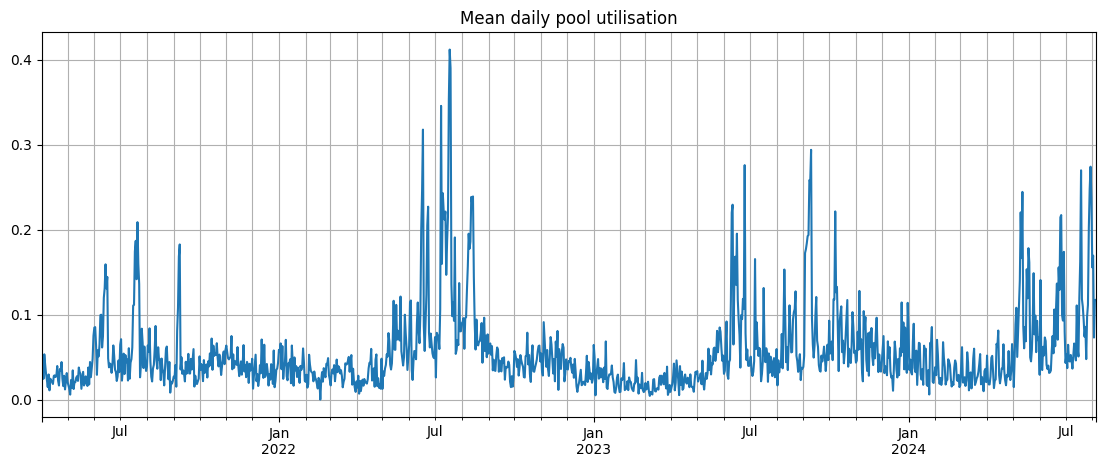

In [16]:
booked.util.groupby(booked.index.normalize()).mean().plot(figsize=(13.6, 5))
plt.title("Mean daily pool utilisation")
plt.grid(which="both");

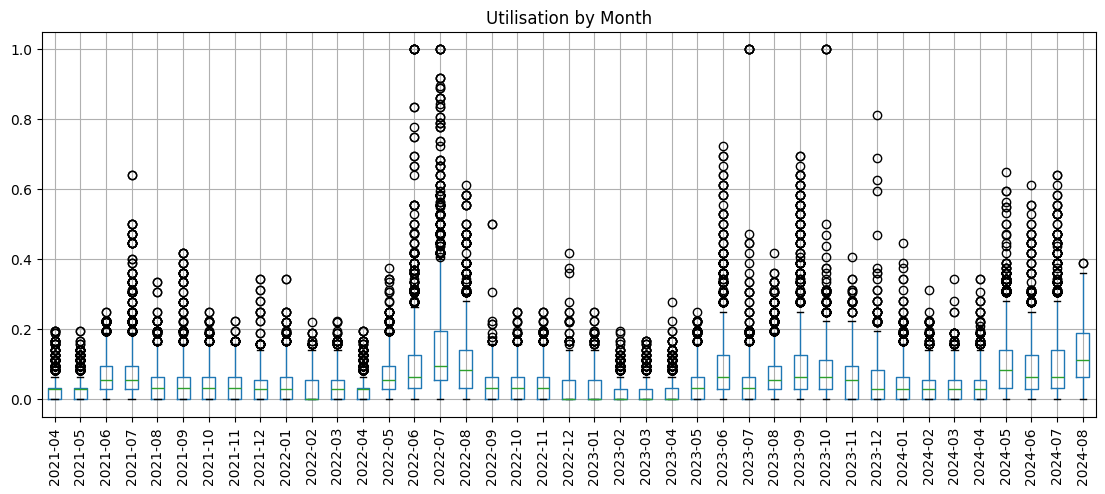

In [17]:
bookedbyMonth = booked.groupby(by=lambda x: f"{x.year}-{x.month:02d}")
ax = bookedbyMonth.boxplot(subplots=False, column="util", rot=90, figsize=(13.6, 5))
plt.title("Utilisation by Month")
locs, labels = plt.xticks()
for x in labels:
    ds = x.get_text()[1:].split(",")[0]
    x.set_text(ds)
plt.xticks(locs, labels);
# bookedbyWeek.util.describe()

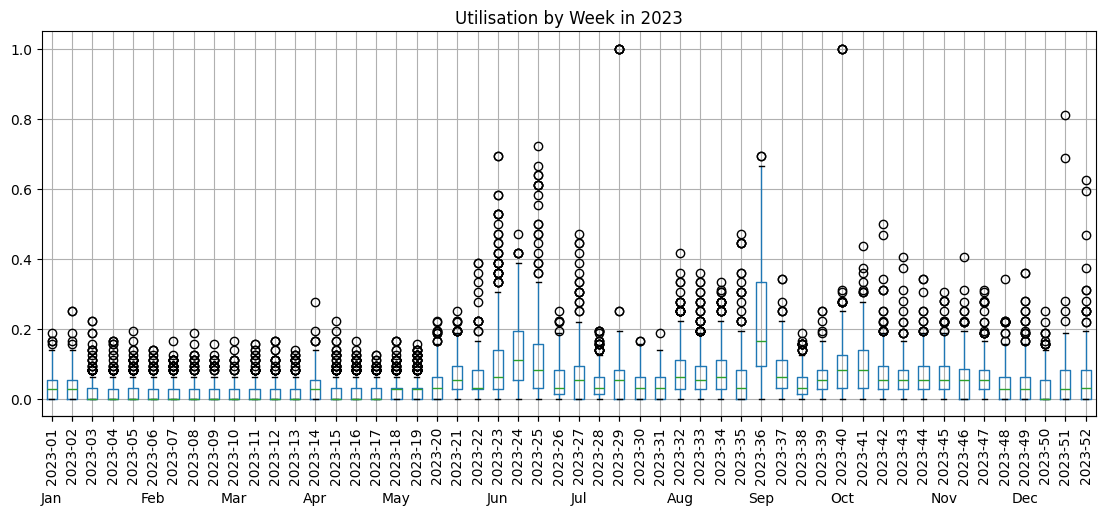

In [18]:
firstWeek, lastWeek = [next(y for i in range(1, 7) if (y := pd.to_datetime(f"20{j:02d}-01-{i:02d}")).weekofyear == 1) for j in [23, 24]]
booked2023 = booked[(booked.index >= firstWeek) & (booked.index < lastWeek)]
bookedbyWeek = booked2023.groupby(by=lambda x: f"{x.year - (0 if x.day_of_year >= x.weekofyear else 1)}-{x.weekofyear:02d}")
ax = bookedbyWeek.boxplot(subplots=False, column="util", rot=90, figsize=(13.6, 5))
plt.title("Utilisation by Week in 2023")
locs, labels = plt.xticks()
secLabels, lastMonth = [], ""
for x in labels:
    ds = x.get_text()[1:].split(",")[0]
    x.set_text(ds)
    monthName = pd.to_datetime(ds + "-1", format="%Y-%W-%w").strftime("%b")
    if monthName != lastMonth:
        secLabels.append("\n\n\n\n" + monthName)
        lastMonth = monthName
    else:
        secLabels.append("")
plt.xticks(locs, labels)
sec = ax.secondary_xaxis(location=0)
sec.set_xticks(locs, secLabels);
# bookedbyWeek.util.describe()

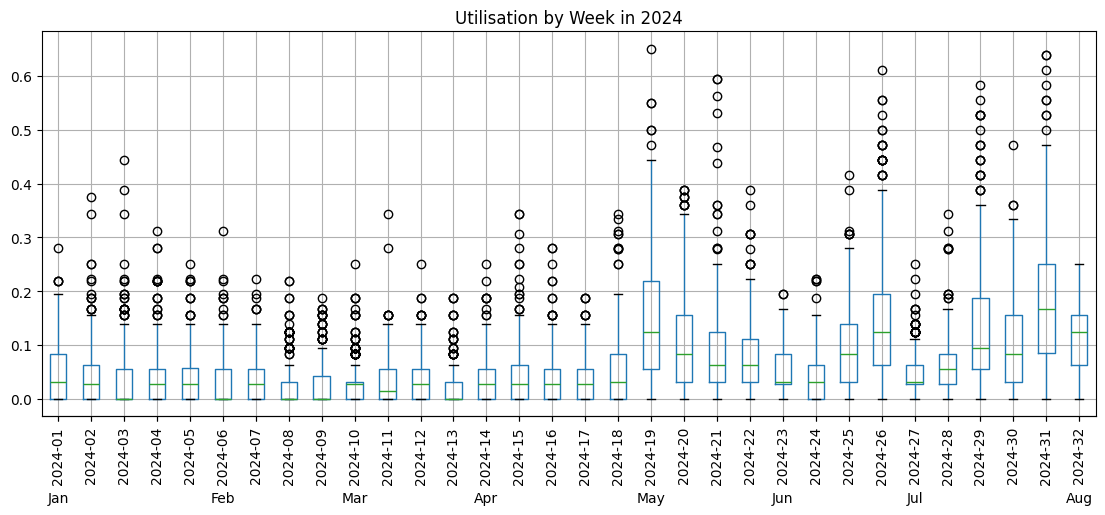

In [19]:
firstWeek, lastWeek = [next(y for i in range(1, 7) if (y := pd.to_datetime(f"20{j:02d}-01-{i:02d}")).weekofyear == 1) for j in [24, 25]]
booked2024 = booked[(booked.index >= firstWeek) & (booked.index < lastWeek)]
bookedbyWeek = booked2024.groupby(by=lambda x: f"{x.year - (0 if x.day_of_year >= x.weekofyear else 1)}-{x.weekofyear:02d}")
ax = bookedbyWeek.boxplot(subplots=False, column="util", rot=90, figsize=(13.6, 5))
plt.title("Utilisation by Week in 2024")
locs, labels = plt.xticks()
secLabels, lastMonth = [], ""
for x in labels:
    ds = x.get_text()[1:].split(",")[0]
    x.set_text(ds)
    monthName = pd.to_datetime(ds + "-1", format="%Y-%W-%w").strftime("%b")
    if monthName != lastMonth:
        secLabels.append("\n\n\n\n" + monthName)
        lastMonth = monthName
    else:
        secLabels.append("")
plt.xticks(locs, labels)
sec = ax.secondary_xaxis(location=0)
sec.set_xticks(locs, secLabels);
# bookedbyWeek.util.describe()

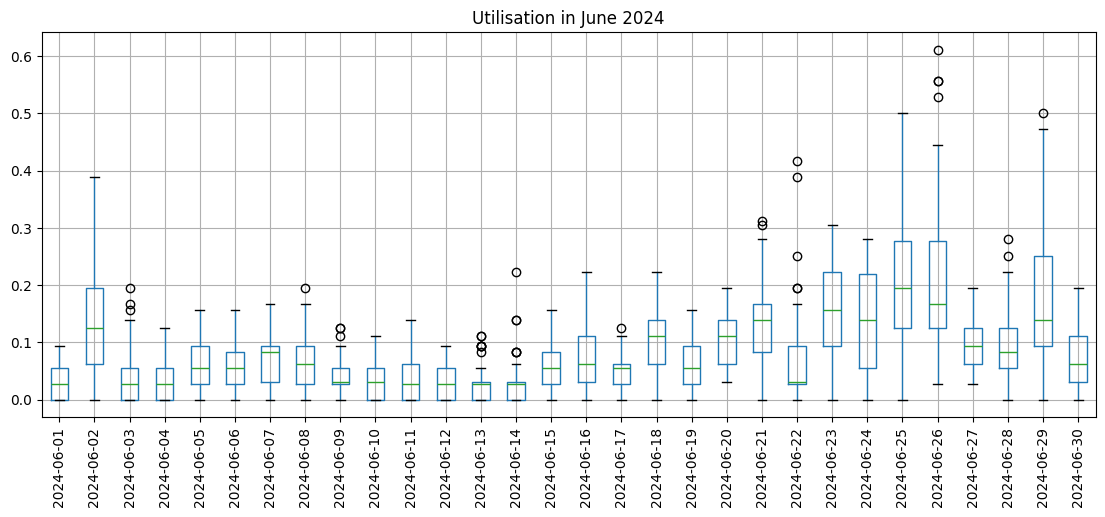

In [20]:
june = booked[(booked.index >= pd.to_datetime("2024-06-01")) & (booked.index < pd.to_datetime("2024-07-01"))]
june = june.groupby(june.index.normalize())
june.boxplot(subplots=False, column="util", rot=90, figsize=(13.6, 5))
plt.title("Utilisation in June 2024")
locs, labels = plt.xticks()
for x in labels:
    x.set_text(x.get_text()[1:11])
plt.xticks(locs, labels);

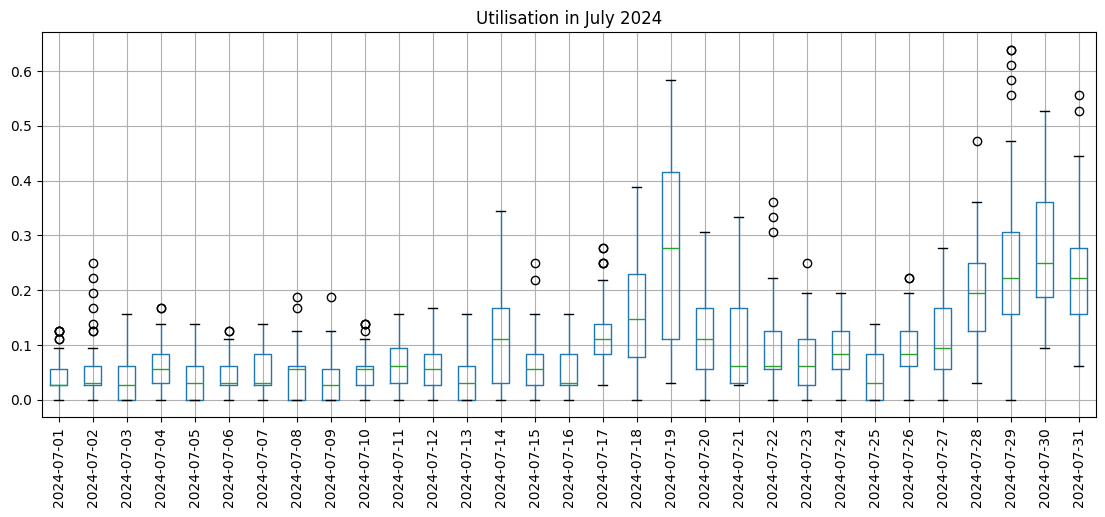

In [21]:
july = booked[(booked.index >= pd.to_datetime("2024-07-01")) & (booked.index < pd.to_datetime("2024-08-01"))]
july = july.groupby(july.index.normalize())
july.boxplot(subplots=False, column="util", rot=90, figsize=(13.6, 5))
plt.title("Utilisation in July 2024")
locs, labels = plt.xticks()
for x in labels:
    x.set_text(x.get_text()[1:11])
plt.xticks(locs, labels);

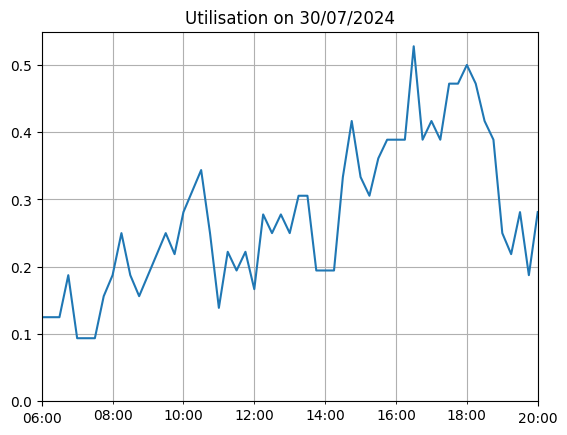

In [22]:
# an example busy day
booked.loc[(booked.index >= pd.to_datetime("2024-07-30")) & (booked.index < pd.to_datetime("2024-07-31")), "util"].plot()
plt.grid(which="both")
plt.ylim(0, plt.ylim()[1])
plt.title("Utilisation on 30/07/2024");

In [23]:
summer = booked[(booked.index >= pd.to_datetime("2024-06-01")) & (booked.index < pd.to_datetime("2024-09-01"))]

,count,mean,std,min,25%,50%,75%,max
Friday,513.0,0.108526,0.105741,0.0,0.031250,0.083333,0.138889,0.583333
Monday,545.0,0.085136,0.096462,0.0,0.027778,0.055556,0.111111,0.638889
Saturday,570.0,0.079312,0.079569,0.0,0.027778,0.062500,0.111111,0.500000
Sunday,570.0,0.108279,0.085267,0.0,0.031250,0.083333,0.156250,0.472222
Thursday,468.0,0.087429,0.073784,0.0,0.031250,0.062500,0.111111,0.388889
Tuesday,513.0,0.098150,0.108254,0.0,0.027778,0.062500,0.138889,0.527778
Wednesday,513.0,0.100458,0.101927,0.0,0.031250,0.062500,0.125000,0.611111


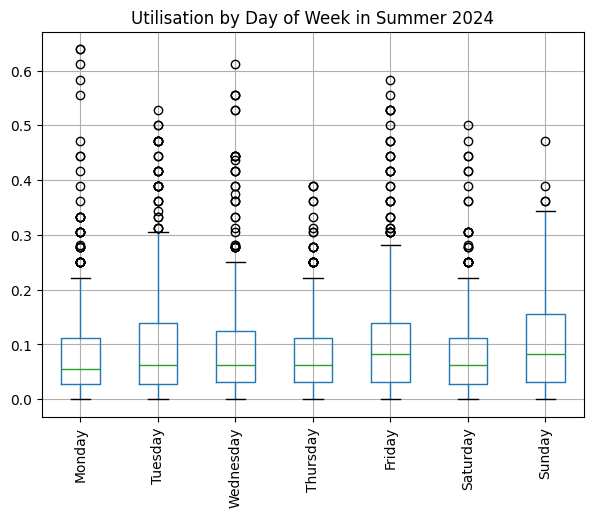

In [24]:
dayOfWeek = summer.groupby(by=lambda x: x.day_name())
dayOfWeek.boxplot(subplots=False, column="util", rot=90, figsize=(7, 5), positions=[5, 1, 6, 7, 4, 2, 3])
plt.title("Utilisation by Day of Week in Summer 2024")
locs, labels = plt.xticks()
for x in labels:
    x.set_text(x.get_text()[1:].split(",")[0])
plt.xticks(locs, labels)
dayOfWeek.util.describe()

,count,mean,std,min,25%,50%,75%,max
6,264.0,0.073390,0.042999,0.0,0.031250,0.062500,0.093750,0.187500
7,264.0,0.076705,0.058873,0.0,0.031250,0.062500,0.093750,0.312500
8,264.0,0.090554,0.062626,0.0,0.031250,0.093750,0.125000,0.312500
9,264.0,0.085582,0.070141,0.0,0.031250,0.062500,0.125000,0.343750
10,264.0,0.087737,0.069641,0.0,0.031250,0.062500,0.125000,0.343750
11,264.0,0.092698,0.071016,0.0,0.027778,0.083333,0.111111,0.277778
12,264.0,0.099642,0.081392,0.0,0.027778,0.083333,0.138889,0.416667
13,264.0,0.084280,0.078018,0.0,0.027778,0.055556,0.111111,0.333333
14,260.0,0.090278,0.096329,0.0,0.027778,0.055556,0.138889,0.472222
15,260.0,0.104274,0.107794,0.0,0.027778,0.055556,0.138889,0.500000


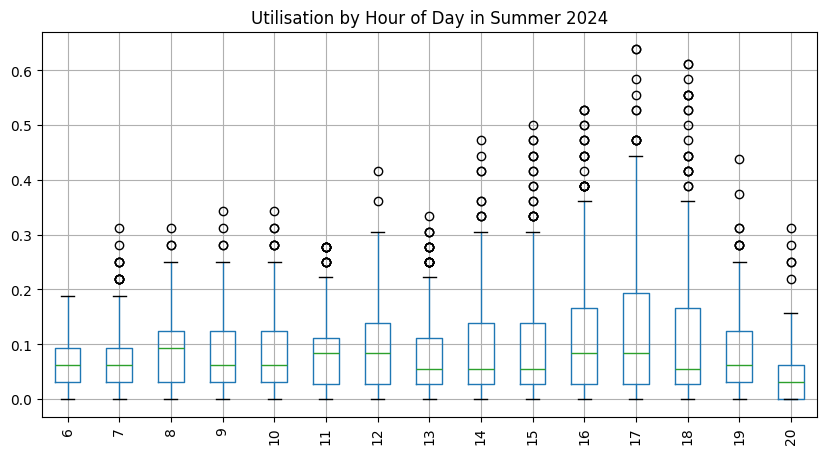

In [25]:
hourOfDay = summer.groupby(by=lambda x: x.hour)
hourOfDay.boxplot(subplots=False, column="util", rot=90, figsize=(10, 5))
plt.title("Utilisation by Hour of Day in Summer 2024")
locs, labels = plt.xticks()
for x in labels:
    x.set_text(x.get_text()[1:].split(",")[0])
plt.xticks(locs, labels)
hourOfDay.util.describe()

## Todo
 * Could also get weather data and use that to correlate it with occupancy.
 * Could do a separate splash pool analysis